Simulation dataset with 2 classes clustered together. The 2 classes are in separate clusters.
Testing if a GNN can accurately predict class based on xyz coordinates only. 
1.0 validation accuracy!

problem posed in Rohan’s illustration can be solved with just xyz as input?

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from graphFeatureSelect.utils import get_adata
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import kneighbors_graph
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv, GCNConv
from torch_geometric.utils import add_remaining_self_loops

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.5, rc=custom_params)
%config InlineBackend.figure_format="retina"

In [97]:
def train_gnn(model, optimizer, data, criterion):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(
        out[data.train_mask], data.y[data.train_mask]
    )  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss


def val_gnn(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    val_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
    val_acc = int(val_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
    return val_acc


def test_gnn(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    ground_truth = data.y.argmax(dim=1)
    test_correct = pred[data.test_mask] == ground_truth[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc


def training_loop(model, data, total_epoch):
    optimizer_self = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    loss_list = []
    for epoch in range(1, total_epoch + 1):
        loss = train_gnn(model, optimizer_self, data, criterion)
        val_acc = test_gnn(model, data)
        if epoch % 200 == 0:
            print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val acc: {val_acc:.4f}")
        loss_list.append(loss.detach().numpy())
    model.eval()
    val_acc = test_gnn(model, data)
    print(f"Model accuracy: {val_acc:.4f}")
    return val_acc, loss_list

In [98]:
# residual connection version 3
# simplest
class GAT3(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes):
        super().__init__()
        torch.manual_seed(1234567)
        self.hidden_channels = hidden_channels
        self.conv1 = GATv2Conv(num_features, hidden_channels, heads=8, concat=False)
        self.conv2 = GATv2Conv(hidden_channels, num_classes, heads=8, concat=False)
        self.lin1 = nn.Linear(num_features, num_classes)

        self.dropout = nn.Dropout(0.25)

    def forward(self, x, edge_index):
        residual1 = self.lin1(x)

        out = self.conv1(x, edge_index)
        out = out.relu()
        out = self.dropout(out)

        out = self.conv2(out, edge_index)
        out = out + residual1

        return out

In [99]:
type1 = torch.FloatTensor(10000, 2).uniform_(0, 2)
type2 = torch.FloatTensor(10000, 2).uniform_(3, 5)

In [100]:
data = torch.concat([type1, type2], dim=0)

In [101]:
labels0 = torch.concat([torch.full((10000, 1), 0), torch.full((10000, 1), 1)], dim=0)
labels = F.one_hot(labels0, num_classes=2)
labels = torch.squeeze(labels)
labels = labels.type(torch.float32)

In [102]:
A = kneighbors_graph(data, n_neighbors=10, mode="distance", include_self=False)
edgelist_knn = torch.tensor(list(zip(A.tocoo().row, A.tocoo().col)))
edgelist_knn = add_remaining_self_loops(edgelist_knn.T)[0]

In [103]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_idx, test_idx = next(skf.split(np.arange(data.shape[0]), labels0))

train_mask = np.zeros(data.shape[0], dtype=bool)
train_mask[train_idx] = True
train_mask = torch.tensor(train_mask, dtype=torch.bool)

test_mask = np.zeros(data.shape[0], dtype=bool)
test_mask[test_idx] = True
test_mask = torch.tensor(test_mask, dtype=torch.bool)

In [104]:
data_knn_xyz = Data(x=data, edge_index=edgelist_knn, y=labels, train_mask=train_mask, test_mask=test_mask)

In [105]:
GAT3_knn = GAT3(
    hidden_channels=32, num_features=data_knn_xyz.x.shape[1], num_classes=torch.unique(data_knn_xyz.y).size()[0]
)

Epoch: 200, Loss: 0.0037, Val acc: 1.0000
Epoch: 400, Loss: 0.0031, Val acc: 1.0000
Epoch: 600, Loss: 0.0028, Val acc: 1.0000
Epoch: 800, Loss: 0.0026, Val acc: 1.0000
Epoch: 1000, Loss: 0.0026, Val acc: 1.0000
Model accuracy: 1.0000


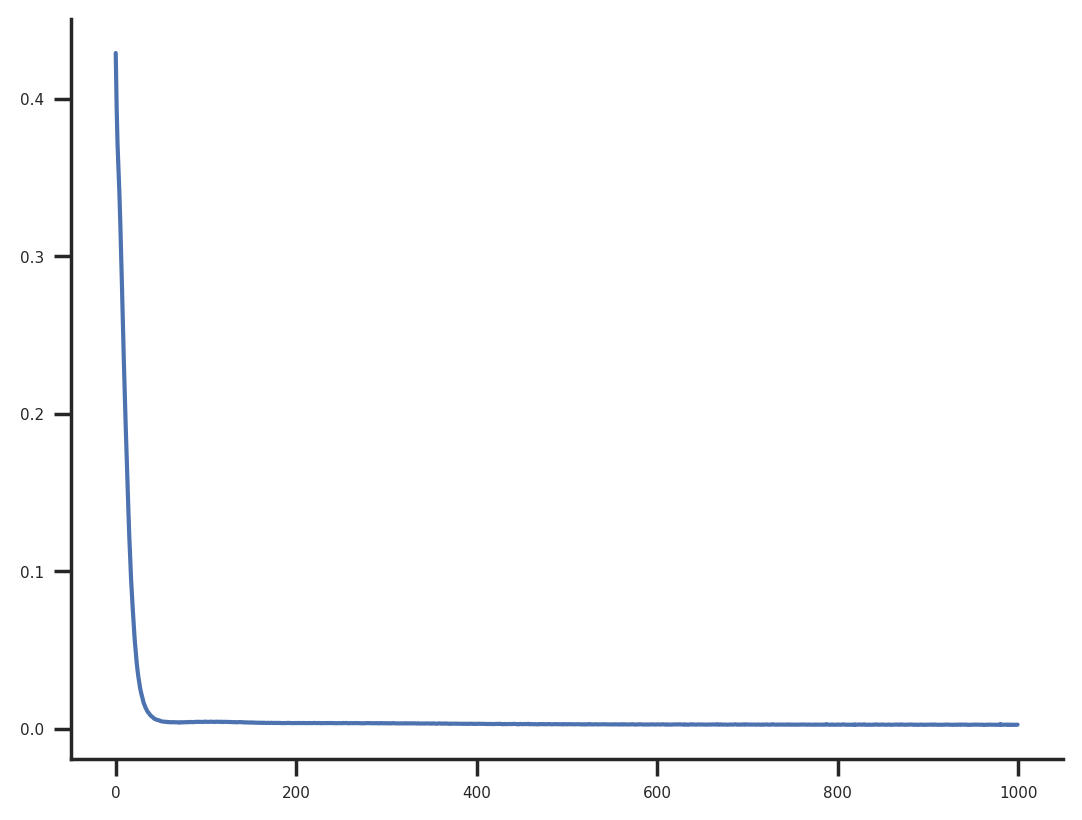

In [106]:
# GAT3 KNN with xyz as input on simulation data
val_acc, loss_list = training_loop(GAT3_knn, data_knn_xyz, 1000)
plt.plot(loss_list)